In [1]:
from xml.etree import ElementTree
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

In [2]:
# Load and parse file
xml_file = '../fruits_dataset/train/mixed_5.xml'
img_file = '../fruits_dataset/train/mixed_5.jpg'
label_names = ['apple', 'banana', 'orange']

input_shape = (448, 448, 3)

In [11]:
# Function to extract bounding box from an annotation file
def extract_boxes(filename):
    # Load and parse the file
    tree = ElementTree.parse(filename)
    # Get the root of the document
    root = tree.getroot()
    boxes = list()
    labels = list()
    
    # Extract each bounding box
    for box in root.findall('.//object'):
        label = label_names.index(box.find('name').text)
        xmin = int(box.find('bndbox/xmin').text)
        ymin = int(box.find('bndbox/ymin').text)
        xmax = int(box.find('bndbox/xmax').text)
        ymax = int(box.find('bndbox/ymax').text)
        coors = (xmin, ymin, xmax, ymax)
        boxes.append(coors)
        labels.append(label)
        
    # Get width and height of an image
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    
    if (width == 0) or (height == 0):
        img = load_img(filename[:-4] + '.jpg')
        width, height = img.width, img.height
    
    boxes = convert_to_xywh(boxes)
    
    return boxes, labels, width, height


def plot_img(filename):
    img = Image.open(filename)
    plt.figure(figsize=(8, 7))
    plt.imshow(img)
    
    
def draw_bboxes(img_file, boxes, labels, box_format='midpoint'):
    img = Image.open(img_file)
    img = np.array(img)
    
    if box_format == 'corners':
        for (xmin, ymin, xmax, ymax), label in zip(boxes, labels):
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
            img = cv2.putText(img, label_names[label], (xmin, ymin), 0, 1, (255, 0, 0), 2)
            
    if box_format == 'midpoint':
        for (x, y, w, h) , label in zip(boxes, labels):
            xmin, xmax = int(x - (w / 2)), int(x + (w / 2))
            ymin, ymax = int(y - (h / 2)), int(y + (h / 2))
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
            img = cv2.putText(img, label_names[label], (xmin, ymin), 0, 1, (255, 0, 0), 2)
            
    plt.figure(figsize=(8, 7))
    plt.imshow(img)
    
    
def convert_to_xywh(bboxes):
    boxes = list()
    for box in bboxes:
        xmin, ymin, xmax, ymax = box
        
        # Compute width and height of box
        box_width = xmax - xmin
        box_height = ymax - ymin
        
        # Compute x, y center
        x_center = int(xmin + (box_width / 2))
        y_center = int(ymin + (box_height / 2))
        
        
        
        boxes.append((x_center, y_center, box_width, box_height))
        
    return boxes


def convert_bboxes_to_tensor(bboxes, labels, img_width,
                            img_height, grid_size=7):
    num_classes = len(label_names)
    target = np.zeros(shape=(grid_size, grid_size, 5 + num_classes), dtype=np.float32)
    
    for idx, bbox in enumerate(bboxes):
        x_center, y_center, width, height = bbox
        
        # Compute size of each cell in grid
        cell_w, cell_h = img_width / grid_size, img_height / grid_size
        
        # Determine cell i, j of bounding box
        i, j = int(y_center / cell_h), int(x_center / cell_w)
        
        # Compute value of x_center and y_center in cell
        x, y = (x_center / cell_w) - j, (y_center / cell_h) - i
        
        # Normalize width and height of bounding box
        w_norm, h_norm = width / img_width, height / img_height
        
        # Add bounding box to tensor
        # Set x, y, w, h
        target[i, j, :4] += (x, y, w_norm, h_norm)
        # Set obj score
        target[i, j, 4] = 1.
        # Set class dist.
        target[i, j, 5 + labels[idx]] = 1.
    
    return target


def draw_bboxes_from_tensor_output(img_file, target):
    img = Image.open(img_file)
    bboxes = list()
    labels = list()
    grid_size = target.shape[0]
    
    # Get image width and height
    img_width, img_height = img.width, img.height
    
    # Compute size of each cell in grid
    cell_w, cell_h = img_width / grid_size, img_height / grid_size
    
    # Get bboxes info
    for i in range(target.shape[0]):
        for j in range(target.shape[1]):
            
            # Check if box contains obj
            if target[i, j, 4] == 1:
                
                # Get x, y, w, h
                x, y, w, h = target[i, j, :4]
                label_dist = target[i, j, 5:]
                label = label_dist.argmax()
                
                # Convert to x_center, y_center, w, h by img original size
                w, h = int(w * img_width), int(h * img_height)
                x_center = int((x + j) * cell_w)
                y_center = int((y + i) * cell_h)
                
                bboxes.append((x_center, y_center, w, h))
                labels.append(label)
    
    draw_bboxes(img_file, bboxes, labels, 'midpoint')
    
    
def load_image(filename, input_shape):
    image = img_to_array(load_img(filename, target_size=input_shape))
    image = image / 255.
    
    return image


def prepare_data_fn(filename, input_shape):
    img_file = filename + '.jpg'
    xml_file = filename + '.xml'
    
    # Load img
    image = load_image(img_file, input_shape)
    
    # Get target label
    target = extract_boxes(xml_file)
    target = convert_bboxes_to_tensor(*target)
    
    return image, target

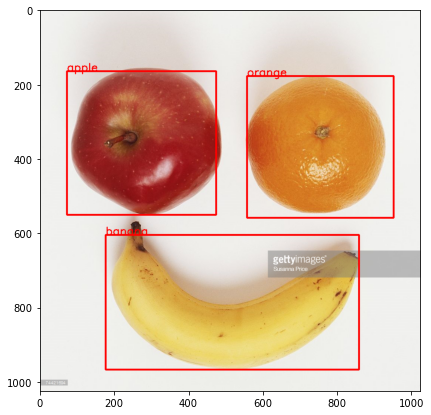

In [12]:
boxes, labels, width, height = extract_boxes(xml_file)
draw_bboxes(img_file, boxes, labels, 'midpoint')

In [13]:
img_01, target_01 = prepare_data_fn('../fruits_dataset/train/mixed_11', input_shape)
img_02, target_02 = prepare_data_fn('../fruits_dataset/train/apple_2', input_shape)
img_03, target_03 = prepare_data_fn('../fruits_dataset/train/orange_2', input_shape)
img_04, target_04 = prepare_data_fn('../fruits_dataset/train/banana_1', input_shape)

In [14]:
batch_input = np.array([img_01, img_02, img_03, img_04])
batch_target = np.array([target_01, target_02, target_03, target_04])

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((batch_input, batch_target))

In [19]:
img_04, target_04 = prepare_data_fn('../fruits_dataset/train/apple_2', input_shape)

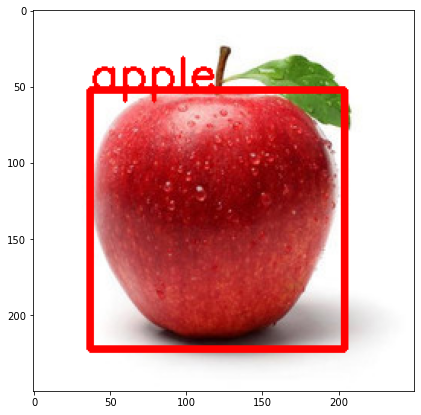

In [20]:
draw_bboxes_from_tensor_output('../fruits_dataset/train/apple_2.jpg', target_04)